In [ ]:
! pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 16.9MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num=classes=100
input_shape=(32,32,3)
(x_train,y_train),(x_test,y_test)=keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 2s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  

In [ ]:
data_augmentation=keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(factor=0.02),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.2,width_factor=0.2),
],name="data_augmentation")

In [ ]:
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x,hidden_units,dropout_rate):
  for units in hidden_units:
    x=layers.Dense(units,activation=tf.nn.gelu)(x)
    x=layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


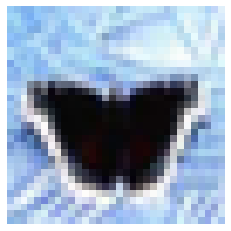

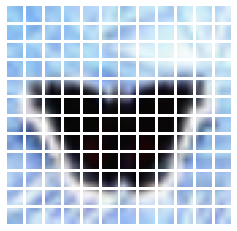

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
patches[0]

<tf.Tensor: shape=(144, 108), dtype=float32, numpy=
array([[150.      , 203.      , 245.      , ..., 143.46605 , 194.73764 ,
        245.57098 ],
       [127.611115, 177.77777 , 237.22223 , ..., 142.84259 , 190.04321 ,
        239.41357 ],
       [144.11111 , 190.77777 , 239.72221 , ..., 158.5679  , 204.60185 ,
        243.67592 ],
       ...,
       [178.54626 , 204.22836 , 248.45987 , ..., 187.33333 , 209.94444 ,
        237.66666 ],
       [193.20676 , 211.65121 , 234.57407 , ..., 149.61111 , 175.11111 ,
        230.5     ],
       [175.36421 , 195.14816 , 237.81792 , ..., 166.      , 195.      ,
        238.      ]], dtype=float32)>

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self,num_patches,projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches=num_patches
    self.projection=layers.Dense(units=projection_dim)
    self.positional_embedding=layers.Embedding(input_dim=num_patches,output_dim=projection_dim)
  def call(self,patch):
    positions=tf.range(start=0,limit=self.num_patches,delta=1)
    encoded=self.projection(patch)+self.positional_embedding(positions)
    return encoded

In [ ]:
def create_vit_classifier():
  inputs=layers.Input(shape=input_shape)
  augmented=data_augmentation(inputs)
  patches=Patches(patch_size)(augmented)
  encoded_patches=PatchEncoder(num_patches,projection_dim)(patches)
  for _ in range(transformer_layers):
    x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output=layers.MultiHeadAttention(num_heads=num_heads,key_dim=projection_dim,dropout=0.1)(x1,x1)
    x2=layers.Add()([attention_output,encoded_patches])
    x3=layers.LayerNormalization(epsilon=1e-6)(x2)
    encoded_patches=layers.Add()([x3,x2])
  representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation=layers.Flatten()(representation)
  representation=layers.Dropout(0.5)(representation)
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  logits = layers.Dense(num_classes)(features)
  model = keras.Model(inputs=inputs, outputs=logits)
  return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)
